# Inverse Transform Example

In [1]:
version = lambda p: print(f"{p.__name__}: {p.__version__}")

In [2]:
try: 
    import umap
except ImportError:
    print("Please install umap-learn to run this notebook: pip install umap-learn")
else:
    version(umap)

umap: 0.4.6


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import numpy as np
from sklearn.datasets import fetch_openml, load_digits

### Load MNIST Dataset

In this notebook, we will download the **MNIST** dataset as available on the [OpenML](https://www.openml.org) platform.

To do so, we will use the `fetch_openml` utility function
included in scikit-learn.

This will download the dataset in the default `data_home`,
which is `$HOME/scikit_learn_data`.

Read more in the
[User Guide](https://scikit-learn.org/stable/datasets/index.html#openml)
on Scikit-learn Documentation

**Note**: In case your machine is struggling with the following computation, you could simply substitute the full **real world** MNIST dataset, with its "toy" version as provided by the `load_digits` function included in `sklearn`.

This will drastically speed-up the computation, although reducing the quality of the results. Please see below for details.

(A) **MNIST** (`fetch_openml`): `70,000` samples, $28 \times 28$ images;

(B) **DIGITS** (`load_digits`): `1797` samepls, $8 \times 8$ each 

###### Load Dataset

In [5]:
# Set this flag to False and re-run the whole notebook to use 
# the Digits "Toy" dataset
USE_HIGH_RESOLUTION_DATA = True  # Using High-res by default

In [6]:
if USE_HIGH_RESOLUTION_DATA:
    # mnist_784 is the name of the dataset in OpenML
    # This may take some time depending on your internet connection
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    y = y.astype(int)
else:
    X, y = load_digits(return_X_y=True)

In [7]:
# Showing shapes of data
X.shape, y.shape

((70000, 784), (70000,))

### UMAP Transformer

Create the UMAP transformer by learning from the MNIST data

In [8]:
trans = umap.UMAP(n_neighbors=10, random_state=42, 
                  metric="euclidean", output_metric="euclidean", 
                  init="spectral", verbose=True)


# NOTE: This may take a while if you're using High Res Data!
trans.fit(X)  # Fitting the transformer with MNIST data

UMAP(n_neighbors=10, random_state=42, verbose=True)
Construct fuzzy simplicial set
Fri Aug 21 16:29:44 2020 Finding Nearest Neighbors
Fri Aug 21 16:29:44 2020 Building RP forest with 18 trees
Fri Aug 21 16:29:54 2020 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	 8  /  16
Fri Aug 21 16:30:11 2020 Finished Nearest Neighbor Search
Fri Aug 21 16:30:15 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Aug 21 16:30:53 2020 Finished embedding


UMAP(n_neighbors=10, random_state=42, verbose=True)

#### Plot generated embedding

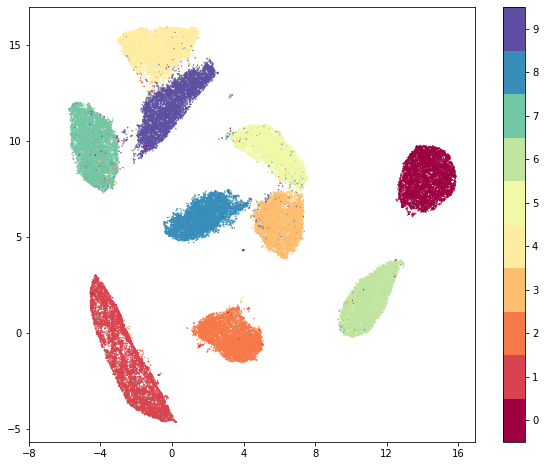

In [9]:
plt.figure(figsize=(10, 8))

plt.scatter(
    trans.embedding_[:, 0],
    trans.embedding_[:, 1],
    c=y, cmap="Spectral",
    s=0.25,
)
plt.yticks(np.arange(-5, 20, 5))
plt.xticks(np.arange(-8, 20, 4))

plt.colorbar(boundaries=np.arange(11) - 0.5).set_ticks(np.arange(10))
plt.show()

---

## Inverse Transformation

Now that we have the UMAP transformer, we are going to generate some 
_out of distribution_ test data which will be then used as input for 
the **inverse transformation**. 

To do so, we will apply the following **4** steps procedure:

1. Select (four) target digits, i.e. `7`, `4`, `1`, `0`
2. Idenitfy the centroids for each digit
3. Generate new `test` points in the area enclosed within centroids
4. Apply UMAP `inverse_transform`


### 1. Select four target classes (digits)

Select samples in the embedding space corresponding to four target digits: `7, 4, 1, 0`

In [10]:
sevens = trans.embedding_[np.where(y == 7)]
fours = trans.embedding_[np.where(y == 4)]
ones = trans.embedding_[np.where(y == 1)]
zeros = trans.embedding_[np.where(y == 0)]

### 2. Identify Centroids

Calculate the coordinates of the centroids for each digit

In [11]:
seven_c = np.mean(sevens, axis=0)
four_c = np.mean(fours, axis=0)
one_c = np.mean(ones, axis=0)
zero_c = np.mean(zeros, axis=0)

##### Plot Centroids

In [12]:
centroids = {7: seven_c, 
             4: four_c, 
             1: one_c, 
             0: zero_c}

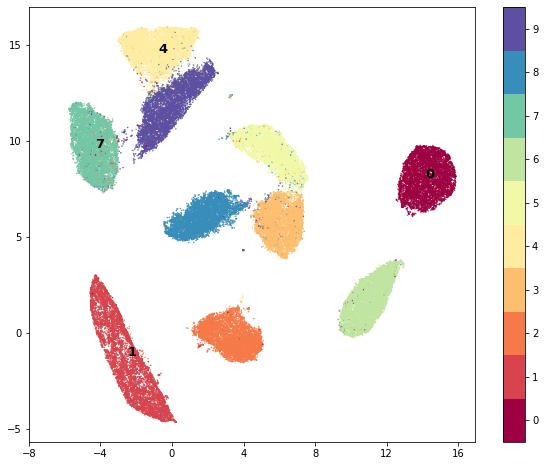

In [13]:
plt.figure(figsize=(10, 8))

plt.scatter(
    trans.embedding_[:, 0],
    trans.embedding_[:, 1],
    c=y, cmap="Spectral",
    s=0.25,
)
plt.yticks(np.arange(-5, 20, 5))
plt.xticks(np.arange(-8, 20, 4))

plt.colorbar(boundaries=np.arange(11) - 0.5).set_ticks(np.arange(10))

# Plot Centroids
for digit, (x1, x2) in centroids.items():
    plt.annotate(digit, (x1, x2), c='k', fontsize=13, fontweight='bold')

plt.show()

### 3. Generate Test Points

In [15]:
test_pts = np.array(
    [
        (centroids[7] * (1 - x1) + centroids[4] * x1) * (1 - x2)
        + (centroids[1] * (1 - x1) + centroids[0] * x1) * x2
        for x1 in np.linspace(0, 1, 10)
        for x2 in np.linspace(0, 1, 10)
    ]
)

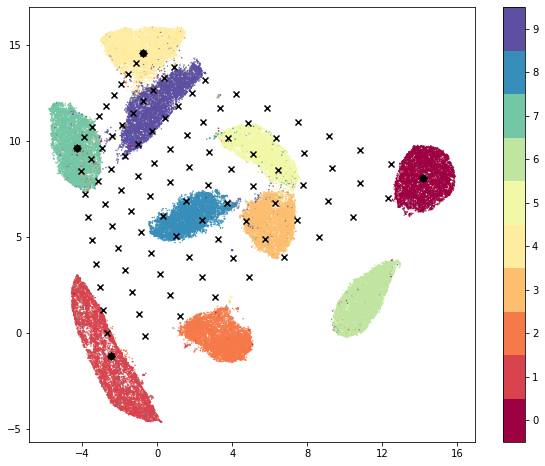

In [16]:
plt.figure(figsize=(10, 8))

plt.scatter(
    trans.embedding_[:, 0],
    trans.embedding_[:, 1],
    c=y, cmap="Spectral",
    s=0.25,
)
plt.yticks(np.arange(-5, 20, 5))
plt.xticks(np.arange(-8, 20, 4))

plt.colorbar(boundaries=np.arange(11) - 0.5).set_ticks(np.arange(10))

# Plot Centroids
for x1, x2 in centroids.values():
    plt.scatter(x1, x2, marker='D', c='k', s=30)

# Plot Test Points
plt.scatter(test_pts[:, 0], test_pts[:, 1], marker="x", c="k")

plt.show()

### 4. Generate UMAP Inverse Transformation

The final step is to apply `umap.inverse_transform` operation.

In performing the inverse transformation, the _transformer_ will apply the 
`output_metric` - in this example the `euclidean` metric - on sample in
the embedding space.

In [17]:
# NOTE: This may take a while for High-res Data
inv_transformed_points = trans.inverse_transform(test_pts)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


#### Visualise the generated reverse transformation of  `test` samples

In [20]:
if USE_HIGH_RESOLUTION_DATA:
    W, H = 28, 28
else:
    W, H = 8, 8

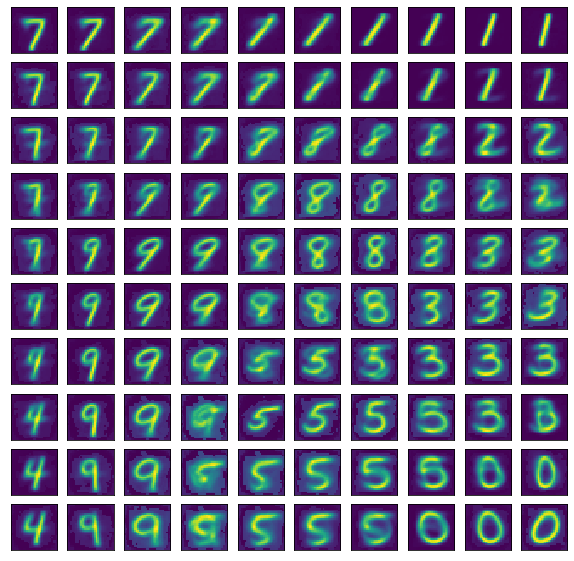

In [21]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(
            inv_transformed_points[i * 10 + j].reshape(W, H), origin="upper"
        )
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

plt.show()